# Predicting the Next Big Hit: Using Machine Learning to Forecast Song Popularity

At **Data Money**, we thrive on empowering our clients in the music industry with data-driven insights.  We understand that accurately predicting a song's potential to resonate with listeners is a coveted goal—a game-changer for artists, labels, and streaming services alike. Imagine the possibilities: discovering new talent, crafting perfect playlists, optimizing marketing campaigns—all guided by a data-driven understanding of what makes a song a hit.

This ambition has led us deep into the fascinating world of machine learning. By training advanced algorithms on vast datasets of musical features and popularity scores, we're building a model that can unlock the secrets behind chart-topping success. 

This notebook details our journey to crack the code of song popularity. We meticulously evaluate a spectrum of powerful regression algorithms, each with unique strengths tailored to capture the nuances within our dataset. Our exploration includes:

**Regression Algorithms Explored:**

* **Linear Regression:** This foundational algorithm assumes a linear relationship between a song's attributes (duration, acousticness, etc.) and its popularity.  Its simplicity allows for interpretability, while potential limitations lie in capturing complex interactions.
* **Decision Tree Regressor:** This method employs a tree-like structure to make predictions based on a sequence of decisions involving song features. Its intuitive visualization aids understanding, but it can be sensitive to minor data fluctuations.
* **Random Forest Regressor:** This ensemble approach combines multiple decision trees, enhancing accuracy and robustness while mitigating the risk of overfitting inherent in individual trees.
* **Polynomial Regression:**  By fitting polynomial curves to the data, this technique can capture non-linear relationships between song characteristics and popularity, offering potentially higher accuracy at the risk of overfitting if not carefully managed.
* **Regularized Regression Models:**  We'll explore variations of Linear and Polynomial Regression incorporating regularization techniques: Lasso, Ridge, and Elastic Net.  These methods help prevent overfitting and improve generalization by adding constraints to the model's parameters.

**Evaluating Predictive Prowess:**

To rigorously assess and compare the performance of our regression models, we'll employ a suite of metrics, each providing a unique perspective on the model's ability to predict song popularity. Understanding the mathematical underpinnings of these metrics allows for a more insightful interpretation of our results. 

Let's delve into the formulas and significance of each metric:

> * **$R^2$ (R-squared)**: This metric, also known as the coefficient of determination, quantifies the proportion of variance in the target variable (song popularity) that is explained by the independent variables (song features) in our model. A higher $R^2$ value, closer to 1, indicates a better fit, suggesting that the model explains a larger portion of the variability in song popularity.
>
>   $$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$
>   where $SS_{res}$ is the sum of squared residuals (difference between predicted and actual values) and $SS_{tot}$ is the total sum of squares (variance of the target variable).


> * **Mean Squared Error (MSE):** MSE measures the average squared difference between the predicted and actual popularity scores. By squaring the errors, MSE gives more weight to larger deviations, penalizing outliers more heavily. A lower MSE indicates better accuracy, with a value of 0 representing a perfect fit (no prediction errors).
> 
>   $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$
>   where $n$ is the number of data points, $y_i$ is the actual popularity of song $i$, and $\hat{y}_i$ is the model's predicted popularity for song $i$.


> * **Root Mean Squared Error (RMSE):** RMSE is simply the square root of the MSE.  It provides an interpretable measure of the average prediction error in the same units as the target variable (song popularity). A lower RMSE suggests more accurate predictions, with a value closer to 0 indicating better performance.
> 
>   $$RMSE = \sqrt{MSE}$$


> * **Mean Absolute Error (MAE):**  MAE calculates the average absolute difference between predicted and actual values, treating all errors equally without squaring. A lower MAE signifies better accuracy, with 0 representing a perfect fit.
> 
>   $$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$


> * **Mean Absolute Percentage Error (MAPE):** This metric expresses the average prediction error as a percentage of the actual values, offering a relative measure of accuracy. A lower MAPE indicates better accuracy, with a value closer to 0 representing more precise predictions.
> 
>   $$MAPE = \frac{100%}{n}  \sum_{i=1}^{n} |\frac{y_i - \hat{y}_i}{y_i}|$$


Through the rigorous evaluation of our models across these metrics, we can confidently identify the best-performing algorithm for predicting song popularity. This, in turn, equips **Data Money** and our clients with actionable insights to make informed decisions and shape the future of music.

# 0 - Imports

In [66]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import statsmodels.api   as sm

from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics         import (r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, 
                                     mean_absolute_percentage_error)
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.pipeline        import Pipeline

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=UserWarning, module='numpy')

# 1 - Loading data

In [2]:
X_train = pd.read_csv('Data/Regression/X_training.csv')
y_train = pd.read_csv('Data/Regression/y_training.csv')

X_val   = pd.read_csv('Data/Regression/X_validation.csv')
y_val   = pd.read_csv('Data/Regression/y_val.csv')

X_test  = pd.read_csv('Data/Regression/X_test.csv')
y_test  = pd.read_csv('Data/Regression/y_test.csv')

# 2 - EDA

In [3]:
X_train.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,0.205673,0.092100,0.720,0.802,0.000000,0.090909,0.694,0.431778,1,0.0582,0.103876,0.8,0.723
1,-0.240409,0.737000,0.483,0.412,0.000000,0.636364,0.116,-0.262732,1,0.0402,1.711532,0.6,0.247
2,-0.125770,0.274000,0.671,0.565,0.000065,1.000000,0.370,0.013612,0,0.1600,1.009176,0.8,0.561
3,-0.580967,0.002340,0.704,0.529,0.874000,1.000000,0.370,-0.266382,0,0.0416,0.666173,0.8,0.507
4,-0.688566,0.000414,0.354,0.910,0.205000,0.090909,0.456,0.422914,1,0.0430,1.182630,0.8,0.362


In [4]:
X_train.describe()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,1.054700e+04,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,10547.000000,1.054700e+04,10547.000000,10547.000000,1.054700e+04,10547.000000,10547.000000
mean,5.995857e-17,0.259502,0.633974,0.645438,0.079089,0.483196,0.180416,2.489291e-16,0.627098,0.100937,-9.499054e-17,0.791581,0.529879
std,1.000047e+00,0.290173,0.156223,0.214348,0.222818,0.327242,0.144705,1.000047e+00,0.483599,0.103352,1.000047e+00,0.060822,0.244461
min,-3.553790e+00,0.000001,0.000000,0.001070,0.000000,0.000000,0.015700,-7.632256e+00,0.000000,0.000000,-4.220028e+00,0.000000,0.000000
25%,-5.810364e-01,0.024600,0.533000,0.512000,0.000000,0.181818,0.092700,-4.243671e-01,0.000000,0.037850,-7.756112e-01,0.800000,0.336000
50%,-1.146491e-01,0.132000,0.645000,0.675000,0.000011,0.454545,0.122000,2.346876e-01,1.000000,0.055200,-3.656695e-02,0.800000,0.532000
75%,4.224443e-01,0.432000,0.748000,0.815000,0.002835,0.727273,0.224000,6.609353e-01,1.000000,0.116000,6.566737e-01,0.800000,0.727000
max,1.969099e+01,0.996000,0.987000,0.999000,0.989000,1.000000,0.984000,2.292930e+00,1.000000,0.941000,4.226719e+00,1.000000,0.982000


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10547 entries, 0 to 10546
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_duration_ms  10547 non-null  float64
 1   acousticness      10547 non-null  float64
 2   danceability      10547 non-null  float64
 3   energy            10547 non-null  float64
 4   instrumentalness  10547 non-null  float64
 5   key               10547 non-null  float64
 6   liveness          10547 non-null  float64
 7   loudness          10547 non-null  float64
 8   audio_mode        10547 non-null  int64  
 9   speechiness       10547 non-null  float64
 10  tempo             10547 non-null  float64
 11  time_signature    10547 non-null  float64
 12  audio_valence     10547 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [6]:
y_train.head()

,song_popularity
0,79.0
1,86.0
2,63.0
3,25.0
4,35.0


# 3 - Model Training

In [7]:
def calculate_metrics(y_true, y_pred):
    """Calculate and return regression metrics """
    r2   =                             r2_score(y_true, y_pred)
    mse  =             float(mean_squared_error(y_true, y_pred))
    rmse =        float(root_mean_squared_error(y_true, y_pred))
    mae  =            float(mean_absolute_error(y_true, y_pred))
    mape = float(mean_absolute_percentage_error(y_true, y_pred))
    
    return {
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

## 3.1 -  Linear Regression

Linear regression is the bedrock of predictive modeling. It assumes a linear relationship between the input features (e.g., song duration, acousticness) and the target variable (song popularity). Its simplicity makes it easy to interpret and computationally efficient, making it a popular choice for tasks like:

* **Predicting Sales:** Forecasting sales based on advertising spend, seasonality, and economic indicators.
* **Estimating House Prices:** Determining property values using features like location, size, and amenities.
* **Analyzing Trends:**  Understanding the relationship between variables over time, such as stock prices or population growth. 


### 3.1.1 - Training

In [8]:
# Definition
lin_reg_model = LinearRegression()

# Training
lin_reg_model.fit(X_train, y_train)

# Performance
yhat_train = lin_reg_model.predict(X_train)
lin_reg_train_metrics = calculate_metrics(y_train, yhat_train)
lin_reg_train_metrics

{'R²': 0.04605830473391903,
 'MSE': 455.99611182562677,
 'RMSE': 21.35406546364478,
 'MAE': 16.998249066011095,
 'MAPE': 8.653185943804514}

Just for the sake of comparison, the regression was calculated using statsmodels to show the results in a different way

In [9]:
# Definition
model_lin_reg = sm.OLS(y_train, sm.add_constant(X_train))

# Training
results = model_lin_reg.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     39.12
Date:                Sun, 01 Sep 2024   Prob (F-statistic):           6.61e-98
Time:                        07:43:58   Log-Likelihood:                -47252.
No. Observations:               10547   AIC:                         9.453e+04
Df Residuals:                   10533   BIC:                         9.463e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               53.5322      3.193  

### 3.1.2 - Validation

In [10]:
# Training
lin_reg_model.fit(X_train, y_train)

# Performance
yhat_val = lin_reg_model.predict(X_val)
lin_reg_val_metrics = calculate_metrics(y_val, yhat_val)
lin_reg_val_metrics

{'R²': 0.0399248303815406,
 'MSE': 458.44704184393123,
 'RMSE': 21.41137645841414,
 'MAE': 17.039753759960327,
 'MAPE': 8.682541883735295}

### 3.1.3 - Test

In [11]:
# Training
lin_reg_model.fit(X_train_val, y_train_val)

# Performance
yhat_test = lin_reg_model.predict(X_test)
lin_reg_test_metrics = calculate_metrics(y_test, yhat_test)
lin_reg_test_metrics

{'R²': 0.05116551777115064,
 'MSE': 461.9884353525593,
 'RMSE': 21.4939162404751,
 'MAE': 17.144197086987703,
 'MAPE': 8.531355027820084}

### 3.1.4 - Results

In [12]:
lin_reg_metrics = pd.DataFrame({
    'train': lin_reg_train_metrics,
    'val': lin_reg_val_metrics,
    'test': lin_reg_test_metrics
})

lin_reg_metrics = lin_reg_metrics.T
lin_reg_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.046058,455.996112,21.354065,16.998249,8.653186
val,0.039925,458.447042,21.411376,17.039754,8.682542
test,0.051166,461.988435,21.493916,17.144197,8.531355


## 3.2 -  Decision Tree Regressor

Decision tree regressors use a tree-like structure to make predictions. They partition data based on feature values, creating branches that lead to predicted outcomes. This approach offers:

* **Intuitive Visualization:**  The tree structure provides a clear representation of the decision-making process.
* **Handling Non-Linear Relationships:**  Decision trees can capture complex, non-linear patterns in data, unlike linear regression.
* **Applications:** Credit risk assessment, medical diagnosis, customer churn prediction. 


### 3.2.1 - Training

In [13]:
# Definition
dt_reg_model = DecisionTreeRegressor(random_state=0)

# Training
dt_reg_model.fit(X_train, y_train)

# Performance
yhat_train = dt_reg_model.predict(X_train)
dt_reg_train_metrics = calculate_metrics(y_train, yhat_train)
dt_reg_train_metrics

{'R²': 0.9917566957405923,
 'MSE': 3.940402971731975,
 'RMSE': 1.9850448286454327,
 'MAE': 0.21409852496986279,
 'MAPE': 0.08262787375974134}

### 3.2.2 - Validation

max_depth tested:  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  

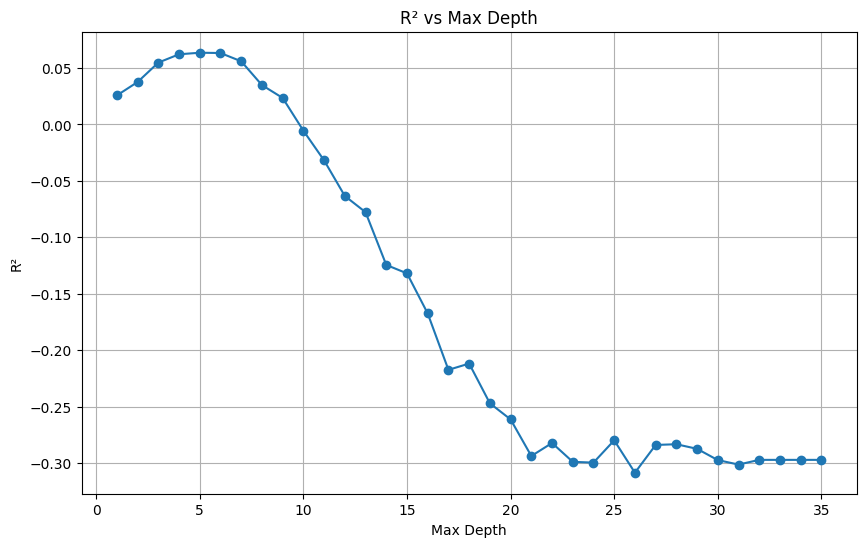

Best max_depth: 5
{'R²': 0.06355927779643322, 'MSE': 447.1613187611445, 'RMSE': 21.146189225511637, 'MAE': 16.843451865846713, 'MAPE': 8.395778483246199}


In [14]:
max_depth_range = range(1,36,1)
dt_reg_val_metrics = {i: None for i in max_depth_range}

print('max_depth tested:', end='  ')
for d in max_depth_range:

    # Definition
    dt_reg_model = DecisionTreeRegressor(random_state=0, max_depth=d)
    
    # Training
    dt_reg_model.fit(X_train, y_train)
    
    # Performance
    yhat_val = dt_reg_model.predict(X_val)
    dt_reg_val_metrics_d = calculate_metrics(y_val, yhat_val)
    dt_reg_val_metrics_d

    # Storing metrics in the dictionary
    dt_reg_val_metrics[d] = {
        'metrics': dt_reg_val_metrics_d
    }

    print(f'{d}', end='  ')

evaluated_metrics = [metrics['metrics']['R²'] for metrics in dt_reg_val_metrics.values()]

plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, evaluated_metrics, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('R²')
plt.title('R² vs Max Depth')
plt.grid(True)
plt.show()

dt_reg_best_max_depth = max(dt_reg_val_metrics, key=lambda k: dt_reg_val_metrics[k]['metrics']['R²'])
dt_reg_val_metrics = dt_reg_val_metrics[dt_reg_best_max_depth]['metrics']
print(f'Best max_depth: {dt_reg_best_max_depth}')
print(dt_reg_val_metrics)

### 3.2.3 - Test

In [15]:
# Definition
dt_reg_model = DecisionTreeRegressor(random_state=0, max_depth=dt_reg_best_max_depth)

# Training
dt_reg_model.fit(X_train_val, y_train_val)

# Performance
yhat_test = dt_reg_model.predict(X_test)
dt_reg_test_metrics = calculate_metrics(y_test, yhat_test)
dt_reg_test_metrics

{'R²': 0.09047547149696622,
 'MSE': 442.84838052138286,
 'RMSE': 21.043963042197703,
 'MAE': 16.82978094998882,
 'MAPE': 7.883226145162679}

### 3.2.4 - Results

In [16]:
dt_reg_metrics = pd.DataFrame({
    'train': dt_reg_train_metrics,
    'val': dt_reg_val_metrics,
    'test': dt_reg_test_metrics
})

dt_reg_metrics = dt_reg_metrics.T
dt_reg_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.991757,3.940403,1.985045,0.214099,0.082628
val,0.063559,447.161319,21.146189,16.843452,8.395778
test,0.090475,442.848381,21.043963,16.829781,7.883226


## 3.3 -  Random Forest Regressor

Random forest regression combines multiple decision trees to improve accuracy and robustness. By averaging the predictions of many trees, it reduces the risk of overfitting and captures a wider range of data patterns. 

* **High Accuracy and Generalization:**  Random forests are known for their excellent predictive performance on a wide variety of tasks.
* **Applications:**  Image classification, object detection, fraud detection, recommendation systems.

### 3.3.1 - Training

In [17]:
# Definition
rf_reg_model = RandomForestRegressor(random_state=0)

# Training
rf_reg_model.fit(X_train, y_train)

# Performance
yhat_train = rf_reg_model.predict(X_train)
rf_reg_train_metrics = calculate_metrics(y_train, yhat_train)
rf_reg_train_metrics

{'R²': 0.9028168842467658,
 'MSE': 46.45474994801846,
 'RMSE': 6.815772146134175,
 'MAE': 4.860772578122971,
 'MAPE': 2.5779585497476467}

### 3.3.2 - Validation

In [19]:
# Define the parameter grid
param_grid = {
    'n_estimators': range(400, 801, 200),
    'max_depth': range(33, 36, 1)
}

# Initialize variables to store the best results
rf_reg_best_score  = -float('inf')
rf_reg_best_params = None
rf_reg_best_model  = None

# Iterate over all combinations of parameters
for params in ParameterGrid(param_grid):
    # Create and train the model with the current parameters
    model = RandomForestRegressor(random_state=0, **params)
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    yhat_val = model.predict(X_val)
    
    # Calculate the R² score
    score = r2_score(y_val, yhat_val)
    
    # Update the best score, parameters, and model if the current model is better
    if score > rf_reg_best_score:
        rf_reg_best_score  = score
        rf_reg_best_params = params
        rf_reg_best_model  = model

# Output the best parameters and metrics
print(f'\nBest parameters: {rf_reg_best_params}')

# Calculate and print metrics on the validation set using the best model
rf_reg_val_metrics = calculate_metrics(y_val, rf_reg_best_model.predict(X_val))
print('Metrics on the validation set:')
print(rf_reg_val_metrics)



Best parameters: {'max_depth': 34, 'n_estimators': 600}
Metrics on the validation set:
{'R²': 0.34104629968710454, 'MSE': 314.65804364111835, 'RMSE': 17.738603204342734, 'MAE': 12.930303888184845, 'MAPE': 7.033137554926378}


### 3.3.3 - Test

In [20]:
# Definition
rf_reg_model = RandomForestRegressor(random_state=0, 
                                     n_estimators=rf_reg_best_params['n_estimators'],
                                     max_depth=rf_reg_best_params['max_depth'])

# Training
rf_reg_model.fit(X_train_val, y_train_val)

# Performance
yhat_test = rf_reg_model.predict(X_test)
rf_reg_test_metrics = calculate_metrics(y_test, yhat_test)
rf_reg_test_metrics

{'R²': 0.407268371434819,
 'MSE': 288.6016083875375,
 'RMSE': 16.988278558686794,
 'MAE': 12.191283580226564,
 'MAPE': 6.317597012337652}

### 3.3.4 - Results

In [21]:
rf_reg_metrics = pd.DataFrame({
    'train': rf_reg_train_metrics,
    'val': rf_reg_val_metrics,
    'test': rf_reg_test_metrics
})

rf_reg_metrics = rf_reg_metrics.T
rf_reg_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.902817,46.454750,6.815772,4.860773,2.577959
val,0.341046,314.658044,17.738603,12.930304,7.033138
test,0.407268,288.601608,16.988279,12.191284,6.317597


## 3.4 -  Polynomial Regression

Polynomial regression extends linear regression by fitting polynomial curves to the data. This allows it to capture non-linear relationships between features and the target variable. However, it requires careful tuning to avoid overfitting.

* **Flexibility for Complex Data:**  Polynomial regression is well-suited for data where the relationship between variables is not strictly linear.
* **Applications:**  Modeling growth curves, predicting stock prices, analyzing chemical reactions.


### 3.4.1 - Training

In [22]:
# Define polynomial model
poly = PolynomialFeatures()
X_poly_train = poly.fit_transform(X_train)

# Model Definition
pol_reg_model = LinearRegression()

# Training
pol_reg_model.fit(X_poly_train, y_train)

# Performance
yhat_train = pol_reg_model.predict(X_poly_train)

pol_reg_train_metrics = calculate_metrics(y_train, yhat_train)
pol_reg_train_metrics

{'R²': 0.09419491057528084,
 'MSE': 432.9862096386579,
 'RMSE': 20.80832068280999,
 'MAE': 16.45803175582444,
 'MAPE': 8.350539820928129}

### 3.4.2 - Validation

Degree tested:  1  2  3  

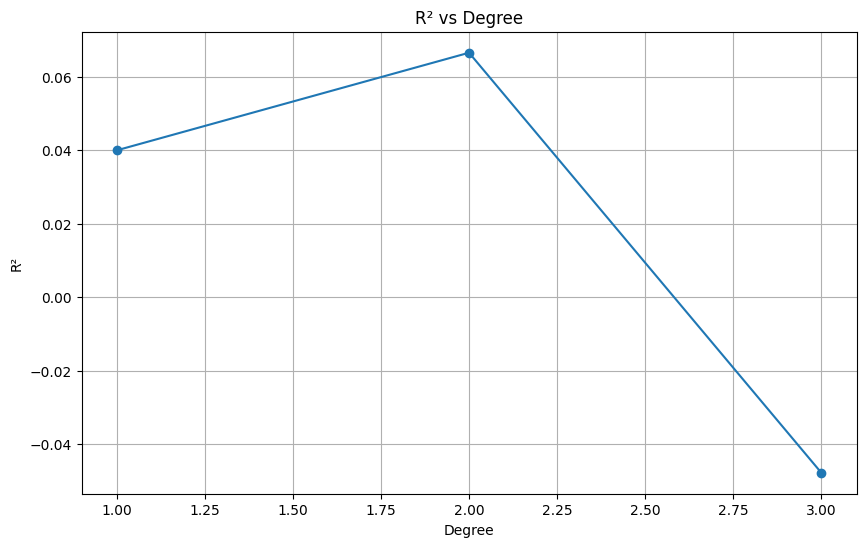

Best degree: 2
{'R²': 0.06647668389711625, 'MSE': 445.7682234712756, 'RMSE': 21.113223900467585, 'MAE': 16.74993909048403, 'MAPE': 8.547931034605392}


In [23]:
degree_range = range(1,4)
pol_reg_val_metrics = {i: None for i in degree_range}

print('Degree tested:', end='  ')
for d in degree_range:

    # Definition
    poly = PolynomialFeatures(degree=d)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_val = poly.fit_transform(X_val)
    
    # Training
    pol_reg_model = LinearRegression()
    pol_reg_model.fit(X_poly_train, y_train)
    
    # Performance
    yhat_val = pol_reg_model.predict(X_poly_val)
    pol_reg_val_metrics_d = calculate_metrics(y_val, yhat_val)
    pol_reg_val_metrics_d

    # Storing metrics in the dictionary
    pol_reg_val_metrics[d] = {
        'metrics': pol_reg_val_metrics_d
    }
    
    print(f'{d}', end='  ')

evaluated_metrics = [metrics['metrics']['R²'] for metrics in pol_reg_val_metrics.values()]

plt.figure(figsize=(10, 6))
plt.plot(degree_range, evaluated_metrics, marker='o')
plt.xlabel('Degree')
plt.ylabel('R²')
plt.title('R² vs Degree')
plt.grid(True)
plt.show()

pol_reg_best_degree = max(pol_reg_val_metrics, key=lambda k: pol_reg_val_metrics[k]['metrics']['R²'])
pol_reg_val_metrics = pol_reg_val_metrics[pol_reg_best_degree]['metrics']
print(f'Best degree: {pol_reg_best_degree}')
print(pol_reg_val_metrics)

### 3.4.3 - Test

In [24]:
# Define polynomial model
poly = PolynomialFeatures(degree=pol_reg_best_degree)
X_poly_train_val = poly.fit_transform(X_train_val)

# Model Definition
pol_reg_model = LinearRegression()

# Training
pol_reg_model.fit(X_poly_train_val, y_train_val)

# Performance
yhat_test = pol_reg_model.predict(X_poly_train_val)

pol_reg_test_metrics = calculate_metrics(y_train_val, yhat_test)
pol_reg_test_metrics

{'R²': 0.08842233682193112,
 'MSE': 435.6086240978977,
 'RMSE': 20.87123916057448,
 'MAE': 16.539642685177714,
 'MAPE': 8.42277271290495}

### 3.4.4 - Results

In [25]:
pol_reg_metrics = pd.DataFrame({
    'train': pol_reg_train_metrics,
    'val': pol_reg_val_metrics,
    'test': pol_reg_test_metrics
})

pol_reg_metrics = pol_reg_metrics.T
pol_reg_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.094195,432.986210,20.808321,16.458032,8.350540
val,0.066477,445.768223,21.113224,16.749939,8.547931
test,0.088422,435.608624,20.871239,16.539643,8.422773


## 3.5 -  Linear Regression Lasso

Linear Regression Lasso combines the simplicity of linear regression with the power of L1 regularization, also known as Lasso (Least Absolute Shrinkage and Selection Operator). This technique adds a penalty to the sum of the absolute values of the model's coefficients. The effect? It shrinks some coefficients to exactly zero, effectively performing feature selection.

* **Key Advantage:**  Lasso helps identify the most important features that drive the target variable (e.g., song popularity), simplifying the model and improving interpretability.
* **Applications:**
    * **Gene Expression Analysis:** Identifying the most relevant genes associated with a particular disease.
    * **Image Processing:**  Selecting the most informative pixels in an image for object recognition.
    * **Marketing Analytics:**  Determining the most effective marketing channels for driving customer acquisition.


### 3.5.1 - Training

In [26]:
# Definition
lasso = Lasso(random_state=0)

# Training
lasso.fit(X_train, y_train)

# Performance
yhat_train = lasso.predict(X_train)
lasso_train_metrics = calculate_metrics(y_train, yhat_train)
lasso_train_metrics

{'R²': 0.007400905609184383,
 'MSE': 474.47483414340275,
 'RMSE': 21.782443254681112,
 'MAE': 17.305483795260546,
 'MAPE': 8.736697313910927}

### 3.5.2 - Validation

In [27]:
alpha_range = np.arange(0, 2, 0.5)
max_iter_range = range(100, 501, 100)
lasso_val_metrics = {}

print('Testing combinations of alpha and max_iter:')
for alpha in alpha_range:
    for max_iter in max_iter_range:

        # Definição do modelo Lasso com os parâmetros alpha e max_iter
        lasso = Lasso(alpha=alpha, max_iter=max_iter, random_state=0)
        
        # Treinamento
        lasso.fit(X_train, y_train)
        
        # Desempenho

        yhat_val = lasso.predict(X_val)
        lasso_val_metrics[(alpha, max_iter)] = calculate_metrics(y_val, yhat_val)

        print(f'(alpha={alpha}, max_iter={max_iter})')

lasso_best_combination = max(lasso_val_metrics, key=lambda k: lasso_val_metrics[k]['R²'])

# Accessing the metrics of the best combination
lasso_val_metrics_best = lasso_val_metrics[lasso_best_combination]

# Displaying the best combination and its metrics
print(f'\nBest Combination (alpha, max_iter): {lasso_best_combination}')
print(lasso_val_metrics_best)

Testing combinations of alpha and max_iter:
(alpha=0.0, max_iter=100)
(alpha=0.0, max_iter=200)
(alpha=0.0, max_iter=300)
(alpha=0.0, max_iter=400)
(alpha=0.0, max_iter=500)
(alpha=0.5, max_iter=100)
(alpha=0.5, max_iter=200)
(alpha=0.5, max_iter=300)
(alpha=0.5, max_iter=400)
(alpha=0.5, max_iter=500)
(alpha=1.0, max_iter=100)
(alpha=1.0, max_iter=200)
(alpha=1.0, max_iter=300)
(alpha=1.0, max_iter=400)
(alpha=1.0, max_iter=500)
(alpha=1.5, max_iter=100)
(alpha=1.5, max_iter=200)
(alpha=1.5, max_iter=300)
(alpha=1.5, max_iter=400)
(alpha=1.5, max_iter=500)

Best Combination (alpha, max_iter): (np.float64(0.0), 200)
{'R²': 0.03992483038154071, 'MSE': 458.4470418439312, 'RMSE': 21.41137645841414, 'MAE': 17.039753759960327, 'MAPE': 8.682541883735295}


### 3.5.3 - Test

In [28]:
# Definition
lasso = Lasso(random_state=0,
              alpha=lasso_best_combination[0],
              max_iter=lasso_best_combination[1])

# Training
lasso.fit(X_train_val, y_train_val)

# Performance
yhat_test = lasso.predict(X_test)
lasso_test_metrics = calculate_metrics(y_test, yhat_test)
lasso_test_metrics

{'R²': 0.05116551777115064,
 'MSE': 461.9884353525593,
 'RMSE': 21.4939162404751,
 'MAE': 17.144197086987703,
 'MAPE': 8.531355027820084}

### 3.5.4 - Results

In [29]:
lasso_metrics = pd.DataFrame({
    'train': lasso_train_metrics,
    'val': lasso_val_metrics_best,
    'test': lasso_test_metrics
})

lasso_metrics = lasso_metrics.T
lasso_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.007401,474.474834,21.782443,17.305484,8.736697
val,0.039925,458.447042,21.411376,17.039754,8.682542
test,0.051166,461.988435,21.493916,17.144197,8.531355


## 3.6 -  Linear Regression Ridge

Linear Regression Ridge employs L2 regularization, which adds a penalty to the sum of the squared values of the model's coefficients. This technique shrinks the magnitude of all coefficients without forcing them to zero. The result is a more stable and robust model, less sensitive to outliers and multicollinearity (high correlation between features). 

* **Key Advantage:**  Ridge helps prevent overfitting by reducing the model's complexity and improving its ability to generalize to new data.
* **Applications:**
    * **Financial Modeling:**  Predicting stock prices or market trends, where fluctuations can be significant.
    * **Medical Imaging:**  Analyzing medical images with noisy data, where robustness is crucial.
    * **Text Analysis:**  Classifying documents or sentiment analysis, where high dimensionality can lead to overfitting.


### 3.6.1 - Training

In [30]:
# Definition
ridge = Ridge(random_state=0)

# Training
ridge.fit(X_train, y_train)

# Performance
yhat_train = ridge.predict(X_train)
ridge_train_metrics = calculate_metrics(y_train, yhat_train)
ridge_train_metrics

{'R²': 0.04605770063554282,
 'MSE': 455.99640059223805,
 'RMSE': 21.354072225040312,
 'MAE': 16.9983076023201,
 'MAPE': 8.653414734181558}

### 3.6.2 - Validation

In [31]:
alpha_range = np.arange(0, 2, 0.5)
max_iter_range = range(100, 501, 100)
ridge_val_metrics = {}

print('Testing combinations of alpha and max_iter:')
for alpha in alpha_range:
    for max_iter in max_iter_range:

        # Definição do modelo ridge com os parâmetros alpha e max_iter
        ridge = Ridge(alpha=alpha, max_iter=max_iter, random_state=0)
        
        # Treinamento
        ridge.fit(X_train, y_train)
        
        # Desempenho
        yhat_val = ridge.predict(X_val)
        ridge_val_metrics[(alpha, max_iter)] = calculate_metrics(y_val, yhat_val)

        print(f'(alpha={alpha}, max_iter={max_iter})')

ridge_best_combination = max(ridge_val_metrics, key=lambda k: ridge_val_metrics[k]['R²'])

# Accessing the metrics of the best combination
ridge_val_metrics_best = ridge_val_metrics[ridge_best_combination]

# Displaying the best combination and its metrics
print(f'\nBest Combination (alpha, max_iter): {ridge_best_combination}')
print(ridge_val_metrics_best)

Testing combinations of alpha and max_iter:
(alpha=0.0, max_iter=100)
(alpha=0.0, max_iter=200)
(alpha=0.0, max_iter=300)
(alpha=0.0, max_iter=400)
(alpha=0.0, max_iter=500)
(alpha=0.5, max_iter=100)
(alpha=0.5, max_iter=200)
(alpha=0.5, max_iter=300)
(alpha=0.5, max_iter=400)
(alpha=0.5, max_iter=500)
(alpha=1.0, max_iter=100)
(alpha=1.0, max_iter=200)
(alpha=1.0, max_iter=300)
(alpha=1.0, max_iter=400)
(alpha=1.0, max_iter=500)
(alpha=1.5, max_iter=100)
(alpha=1.5, max_iter=200)
(alpha=1.5, max_iter=300)
(alpha=1.5, max_iter=400)
(alpha=1.5, max_iter=500)

Best Combination (alpha, max_iter): (np.float64(1.5), 100)
{'R²': 0.03992955619248495, 'MSE': 458.4447852143294, 'RMSE': 21.411323761372845, 'MAE': 17.039331077459902, 'MAPE': 8.682348600505266}


### 3.6.3 - Test

In [32]:
# Definition
ridge = Ridge(random_state=0,
              alpha=ridge_best_combination[0],
              max_iter=ridge_best_combination[1])

# Training
ridge.fit(X_train_val, y_train_val)

# Performance
yhat_test = ridge.predict(X_test)
ridge_test_metrics = calculate_metrics(y_test, yhat_test)
ridge_test_metrics

{'R²': 0.051167062631854,
 'MSE': 461.98768315837515,
 'RMSE': 21.49389874262869,
 'MAE': 17.143837970013415,
 'MAPE': 8.532387164061522}

### 3.6.4 - Results

In [33]:
ridge_metrics = pd.DataFrame({
    'train': ridge_train_metrics,
    'val': ridge_val_metrics_best,
    'test': ridge_test_metrics
})

ridge_metrics = ridge_metrics.T
ridge_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.046058,455.996401,21.354072,16.998308,8.653415
val,0.039930,458.444785,21.411324,17.039331,8.682349
test,0.051167,461.987683,21.493899,17.143838,8.532387


## 3.7 -  Linear Regression ElasticNet

Linear Regression Elastic Net combines the strengths of Lasso and Ridge regularization. It uses a penalty that includes both the sum of absolute values and the sum of squared values of the coefficients. This hybrid approach offers:

* **Feature Selection and Stability:** Elastic Net can perform feature selection like Lasso while maintaining the stability and robustness of Ridge. 
* **Applications:**
    * **Genomics:**  Analyzing complex gene interactions, where both feature selection and stability are essential.
    * **Climate Modeling:**  Predicting weather patterns, which involve many interconnected variables.
    * **Recommendation Systems:**  Improving the accuracy of recommendations by considering both user preferences and item features.


### 3.7.1 - Training

In [34]:
# Definition
elasticnet = ElasticNet(random_state=0)

# Training
elasticnet.fit(X_train, y_train)

# Performance
yhat_train = elasticnet.predict(X_train)
elasticnet_train_metrics = calculate_metrics(y_train, yhat_train)
elasticnet_train_metrics

{'R²': 0.007831741118630053,
 'MSE': 474.2688893586024,
 'RMSE': 21.777715430196125,
 'MAE': 17.299506969671594,
 'MAPE': 8.732300419042266}

### 3.7.2 - Validation

In [35]:
# Defining the parameter ranges
alpha_range = np.arange(0, 1.1, 0.1)
l1_ratio_range = np.arange(0, 1.1, 0.1)
max_iter_range = range(100, 501, 100)

# Creating the parameter grid for GridSearchCV
param_grid = {
    'alpha': alpha_range,
    'l1_ratio': l1_ratio_range,
    'max_iter': max_iter_range
}

# Defining the ElasticNet model
elasticnet = ElasticNet(random_state=0)

# Setting up GridSearchCV
grid_search = GridSearchCV(estimator=elasticnet, param_grid=param_grid, scoring='r2', cv=5)

# Training the model
grid_search.fit(X_train, y_train)

# Prediction and evaluation on the validation set
yhat_val = grid_search.best_estimator_.predict(X_val)

# Storing the best metrics
elasticnet_best_params = grid_search.best_params_
# elasticnet_best_score = grid_search.best_score_

# Displaying the best parameter combination and the best metric
print(f'Best combination (alpha, l1_ratio, max_iter): {elasticnet_best_params}')

# Calculating metrics for the validation set using the best model
best_elasticnet = grid_search.best_estimator_
elasticnet_val_metrics_best = calculate_metrics(y_val, yhat_val)

print('\nMetrics on the validation set:')
elasticnet_val_metrics_best

Best combination (alpha, l1_ratio, max_iter): {'alpha': np.float64(0.0), 'l1_ratio': np.float64(0.0), 'max_iter': 400}

Metrics on the validation set:


{'R²': 0.03992483038154071,
 'MSE': 458.4470418439312,
 'RMSE': 21.41137645841414,
 'MAE': 17.039753759960327,
 'MAPE': 8.682541883735295}

### 3.5.3 - Test

In [36]:
# Definition
elasticnet = ElasticNet(random_state=0,
                        alpha=elasticnet_best_params['alpha'],
                        max_iter=elasticnet_best_params['max_iter'],
                        l1_ratio=elasticnet_best_params['l1_ratio'])

# Training
elasticnet.fit(X_train_val, y_train_val)

# Performance
yhat_test = elasticnet.predict(X_test)
elasticnet_test_metrics = calculate_metrics(y_test, yhat_test)
elasticnet_test_metrics

{'R²': 0.05116551777115064,
 'MSE': 461.9884353525593,
 'RMSE': 21.4939162404751,
 'MAE': 17.144197086987703,
 'MAPE': 8.531355027820084}

### 3.7.4 - Results

In [37]:
elasticnet_metrics = pd.DataFrame({
    'train': elasticnet_train_metrics,
    'val': elasticnet_val_metrics_best,
    'test': elasticnet_test_metrics
})

elasticnet_metrics = elasticnet_metrics.T
elasticnet_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.007832,474.268889,21.777715,17.299507,8.732300
val,0.039925,458.447042,21.411376,17.039754,8.682542
test,0.051166,461.988435,21.493916,17.144197,8.531355


## 3.8 - Polynomial Regression Lasso

Polynomial Regression Lasso extends polynomial regression by adding L1 regularization. This combination allows the model to capture non-linear relationships while also performing feature selection.

* **Key Advantage:** Polynomial Regression Lasso can handle more complex data patterns than linear models while still maintaining a degree of simplicity by selecting the most relevant features. 
* **Applications:** 
    * **Modeling Growth Curves:**  Predicting the growth of populations, organisms, or businesses over time.
    * **Analyzing Chemical Reactions:**  Understanding the non-linear relationships between reactants and products. 
    * **Signal Processing:** Extracting meaningful information from complex signals, such as audio or sensor data.

**10. Polynomial Regression Ridge:  Non-Linearity with Stability**

Polynomial Regression Ridge combines polynomial regression with L2 regularization. This approach allows the model to capture non-linear relationships while reducing the risk of overfitting due to the high dimensionality of polynomial features.

* **Key Advantage:** Polynomial Regression Ridge offers a balance between flexibility (to model non-linear patterns) and stability (to avoid overfitting). 
* **Applications:**
    * **Economic Forecasting:**  Predicting economic indicators like GDP growth or inflation, where trends can be non-linear.
    * **Image Recognition:**  Classifying images with complex features, where overfitting can be a challenge.
    * **Robotics:**  Controlling robotic movements in environments with non-linear dynamics.

**11. Polynomial Regression Elastic Net:  The Ultimate Flexibility**

Polynomial Regression Elastic Net combines polynomial regression with both L1 and L2 regularization, offering the greatest flexibility in terms of model complexity and feature selection. 

* **Key Advantage:** Polynomial Regression Elastic Net is well-suited for datasets with complex relationships and potentially many features, as it can capture non-linear patterns while simultaneously performing feature selection and ensuring model stability.
* **Applications:** 
    * **Bioinformatics:** Analyzing biological data with complex interactions, such as protein folding or gene networks.
    * **Financial Risk Management:**  Modeling financial risk, where complex interactions between market factors can lead to non-linear outcomes.
    * **Artificial Intelligence:**  Developing sophisticated AI systems that require both powerful predictive capabilities and the ability to handle large, complex datasets.

By understanding the strengths and weaknesses of these diverse regression algorithms, we can select the most appropriate tools for predicting song popularity and other real-world phenomena, unlocking a deeper understanding of the factors that drive success. 


### 3.8.1 - Training

In [38]:
# Define polynomial model
poly = PolynomialFeatures()
X_poly_train = poly.fit_transform(X_train)

# Model Definition
poly_lasso = Lasso()

# Training
poly_lasso.fit(X_poly_train, y_train)

# Performance
yhat_train = poly_lasso.predict(X_poly_train)

poly_lasso_train_metrics = calculate_metrics(y_train, yhat_train)
poly_lasso_train_metrics

{'R²': 0.009149935251170582,
 'MSE': 473.6387760067563,
 'RMSE': 21.763243692215468,
 'MAE': 17.285449661261286,
 'MAPE': 8.699700898061744}

### 3.8.2 - Validation

In [40]:
# Define the parameter grid
param_grid = {
    'poly__degree': [1,2,3],  # Polynomial degree
    'lasso__alpha': [0, 0.1, 0.2, 0.3],  # Lasso alpha
    'lasso__max_iter': [100, 200, 300]  # Lasso max_iter
}

# Create the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial features
    ('lasso', Lasso())  # Lasso regression
])

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract the best parameters and metrics
poly_lasso_rf_best_params_val = grid_search.best_params_
poly_lasso_rf_best_score_val  = grid_search.best_score_
poly_lasso_rf_best_model_val  = grid_search.best_estimator_

# poly_lasso_rf_best_params_val

print(f'\nBest parameters: {poly_lasso_rf_best_params_val}')

# Use the best model to predict on the validation set
yhat_val = poly_lasso_rf_best_model_val.predict(X_val)

# Calculate and print metrics on the validation set
poly_lasso_val_metrics = calculate_metrics(y_val, yhat_val)
print('Metrics on the validation set:')
poly_lasso_val_metrics


Best parameters: {'lasso__alpha': 0, 'lasso__max_iter': 100, 'poly__degree': 2}
Metrics on the validation set:


{'R²': 0.06686481645590403,
 'MSE': 445.582885667476,
 'RMSE': 21.10883430385193,
 'MAE': 16.743547935836382,
 'MAPE': 8.561794374665688}

### 3.8.3 - Test

In [41]:
# Define polynomial model
poly = PolynomialFeatures(degree=poly_lasso_rf_best_params_val['poly__degree'])
X_poly_train_val = poly.fit_transform(X_train_val)

# Model Definition
poly_lasso = Lasso(
    random_state=0,
    alpha=poly_lasso_rf_best_params_val['lasso__alpha'],
    max_iter=poly_lasso_rf_best_params_val['lasso__max_iter']
)

# Training
poly_lasso.fit(X_poly_train_val, y_train_val)

# Performance
yhat_test = poly_lasso.predict(X_poly_train_val)

poly_lasso_test_metrics = calculate_metrics(y_train_val, yhat_test)
poly_lasso_test_metrics

{'R²': 0.0872685664411691,
 'MSE': 436.15996749779674,
 'RMSE': 20.884443193386716,
 'MAE': 16.551554223838984,
 'MAPE': 8.438346577036388}

### 3.8.4 - Results

In [42]:
poly_lasso_metrics = pd.DataFrame({
    'train': poly_lasso_train_metrics,
    'val': poly_lasso_val_metrics,
    'test': poly_lasso_test_metrics
})

poly_lasso_metrics = poly_lasso_metrics.T
poly_lasso_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.009150,473.638776,21.763244,17.285450,8.699701
val,0.066865,445.582886,21.108834,16.743548,8.561794
test,0.087269,436.159967,20.884443,16.551554,8.438347


## 3.9 - Polynomial Regression Ridge

### 3.9.1 - Training

In [43]:
# Define polynomial model
poly = PolynomialFeatures()
X_poly_train = poly.fit_transform(X_train)

# Model Definition
poly_ridge = Ridge()

# Training
poly_ridge.fit(X_poly_train, y_train)

# Performance
yhat_train = poly_ridge.predict(X_poly_train)

poly_ridge_train_metrics = calculate_metrics(y_train, yhat_train)
poly_ridge_train_metrics

{'R²': 0.09317140761274367,
 'MSE': 433.47545690992723,
 'RMSE': 20.82007341269303,
 'MAE': 16.471971837686482,
 'MAPE': 8.372689165744585}

### 3.9.2 - Validation

In [45]:
# Define the parameter grid
param_grid = {
    'poly__degree': [1,2,3],  # Polynomial degree
    'ridge__alpha': [0, 0.1, 0.2, 0.3],  # Ridge alpha
    'ridge__max_iter': [100, 200, 300]  # Ridge max_iter
}

# Create the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial features
    ('ridge', Ridge())  # Ridge regression
])

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract the best parameters and metrics
poly_ridge_rf_best_params_val = grid_search.best_params_
poly_ridge_rf_best_score_val  = grid_search.best_score_
poly_ridge_rf_best_model_val  = grid_search.best_estimator_

print(f'\nBest parameters: {poly_ridge_rf_best_params_val}')

# Use the best model to predict on the validation set
yhat_val = poly_ridge_rf_best_model_val.predict(X_val)

# Calculate and print metrics on the validation set
poly_ridge_val_metrics = calculate_metrics(y_val, yhat_val)
print('Metrics on the validation set:')
poly_ridge_val_metrics


Best parameters: {'poly__degree': 2, 'ridge__alpha': 0.3, 'ridge__max_iter': 100}
Metrics on the validation set:


{'R²': 0.06757571223420211,
 'MSE': 445.2434246784478,
 'RMSE': 21.10079203912611,
 'MAE': 16.738539783693305,
 'MAPE': 8.560312768436688}

### 3.9.3 - Test

In [46]:
# Define polynomial model
poly = PolynomialFeatures(degree=poly_ridge_rf_best_params_val['poly__degree'])
X_poly_train_val = poly.fit_transform(X_train_val)

# Model Definition
poly_ridge = Ridge(
    random_state=0,
    alpha=poly_ridge_rf_best_params_val['ridge__alpha'],
    max_iter=poly_ridge_rf_best_params_val['ridge__max_iter']
)

# Training
poly_ridge.fit(X_poly_train_val, y_train_val)

# Performance
yhat_test = poly_ridge.predict(X_poly_train_val)

poly_ridge_test_metrics = calculate_metrics(y_train_val, yhat_test)
poly_ridge_test_metrics

{'R²': 0.08828193754812452,
 'MSE': 435.6757156217005,
 'RMSE': 20.87284637086424,
 'MAE': 16.54149675269387,
 'MAPE': 8.428237504187726}

### 3.9.4 - Results

In [47]:
poly_ridge_metrics = pd.DataFrame({
    'train': poly_ridge_train_metrics,
    'val': poly_ridge_val_metrics,
    'test': poly_ridge_test_metrics
})

poly_ridge_metrics = poly_ridge_metrics.T
poly_ridge_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.093171,433.475457,20.820073,16.471972,8.372689
val,0.067576,445.243425,21.100792,16.738540,8.560313
test,0.088282,435.675716,20.872846,16.541497,8.428238


## 3.10 - Polynomial Regression ElasticNet

### 3.10.1 - Training

In [48]:
# Define polynomial model
poly = PolynomialFeatures()
X_poly_train = poly.fit_transform(X_train)

# Model Definition
poly_elasticnet = ElasticNet()

# Training
poly_elasticnet.fit(X_poly_train, y_train)

# Performance
yhat_train = poly_elasticnet.predict(X_poly_train)

poly_elasticnet_train_metrics = calculate_metrics(y_train, yhat_train)
poly_elasticnet_train_metrics

{'R²': 0.012832763427018778,
 'MSE': 471.8783378824533,
 'RMSE': 21.722760825513255,
 'MAE': 17.244236014680347,
 'MAPE': 8.678785850035073}

### 3.10.2 - Validation

In [49]:
# Define the parameter grid
param_grid = {
    'poly__degree': [1, 2, 3],  # Polynomial degree
    'elasticnet__alpha': [0.1, 0.5, 1.0],  # ElasticNet alpha
    'elasticnet__l1_ratio': [0.2, 0.5, 0.8],  # ElasticNet l1_ratio
    'elasticnet__max_iter': [100, 200, 300]  # ElasticNet max_iter
}

# Create the pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  # Polynomial features
    ('elasticnet', ElasticNet())  # ElasticNet regression
])

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Extract the best parameters and metrics
poly_elasticnet_best_params_val = grid_search.best_params_
poly_elasticnet_best_score_val  = grid_search.best_score_
poly_elasticnet_best_model_val  = grid_search.best_estimator_

print(f'\nBest parameters: {poly_elasticnet_best_params_val}')

# Use the best model to predict on the validation set
yhat_val = poly_elasticnet_best_model_val.predict(X_val)

# Calculate and print metrics on the validation set
poly_elasticnet_val_metrics = calculate_metrics(y_val, yhat_val)
print('Metrics on the validation set:')
poly_elasticnet_val_metrics


Best parameters: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8, 'elasticnet__max_iter': 100, 'poly__degree': 2}
Metrics on the validation set:


{'R²': 0.05613123540308984,
 'MSE': 450.7082952580712,
 'RMSE': 21.2298915507845,
 'MAE': 16.83171375665938,
 'MAPE': 8.655237132224752}

### 3.10.3 - Test

In [50]:
# Define polynomial model
poly = PolynomialFeatures(degree=poly_elasticnet_best_params_val['poly__degree'])
X_poly_train_val = poly.fit_transform(X_train_val)

# Model Definition
poly_elasticnet = ElasticNet(
    random_state=0,
    alpha=poly_elasticnet_best_params_val['elasticnet__alpha'],
    l1_ratio=poly_elasticnet_best_params_val['elasticnet__l1_ratio'],
    max_iter=poly_elasticnet_best_params_val['elasticnet__max_iter']
)

# Training
poly_elasticnet.fit(X_poly_train_val, y_train_val)

# Performance
yhat_test = poly_elasticnet.predict(X_poly_train_val)

# Calculate and store metrics for the test set
poly_elasticnet_test_metrics = calculate_metrics(y_train_val, yhat_test)
poly_elasticnet_test_metrics

{'R²': 0.06127463023377222,
 'MSE': 448.58149036258067,
 'RMSE': 21.17974245269712,
 'MAE': 16.802161479317814,
 'MAPE': 8.58271307973785}

### 3.10.4 - Results

In [51]:
poly_elasticnet_metrics = pd.DataFrame({
    'train': poly_elasticnet_train_metrics,
    'val': poly_elasticnet_val_metrics,
    'test': poly_elasticnet_test_metrics
})

poly_elasticnet_metrics = poly_elasticnet_metrics.T
poly_elasticnet_metrics

,R²,MSE,RMSE,MAE,MAPE
train,0.012833,471.878338,21.722761,17.244236,8.678786
val,0.056131,450.708295,21.229892,16.831714,8.655237
test,0.061275,448.581490,21.179742,16.802161,8.582713


# 4 - Trial results


#### On the Training data 

In [52]:
train_metrics_df = pd.DataFrame({
    'Linear Regression': lin_reg_train_metrics,
    'Decision Tree Regressor': dt_reg_train_metrics,
    'Random Forest Regressor': rf_reg_train_metrics,
    'Polynomial Regression': pol_reg_train_metrics,
    'Linear Regression Lasso': lasso_train_metrics,
    'Linear Regression Ridge': ridge_train_metrics,
    'Linear Regression ElasticNet': elasticnet_train_metrics,
    'Polynomial Regression Lasso': poly_lasso_train_metrics,
    'Polynomial Regression Ridge': poly_ridge_train_metrics,
    'Polynomial Regression ElasticNet': poly_elasticnet_train_metrics
}).T

train_metrics_df.style.background_gradient(cmap='coolwarm')

,R²,MSE,RMSE,MAE,MAPE
Linear Regression,0.046058,455.996112,21.354065,16.998249,8.653186
Decision Tree Regressor,0.991757,3.940403,1.985045,0.214099,0.082628
Random Forest Regressor,0.902817,46.454750,6.815772,4.860773,2.577959
Polynomial Regression,0.094195,432.986210,20.808321,16.458032,8.350540
Linear Regression Lasso,0.007401,474.474834,21.782443,17.305484,8.736697
Linear Regression Ridge,0.046058,455.996401,21.354072,16.998308,8.653415
Linear Regression ElasticNet,0.007832,474.268889,21.777715,17.299507,8.732300
Polynomial Regression Lasso,0.009150,473.638776,21.763244,17.285450,8.699701
Polynomial Regression Ridge,0.093171,433.475457,20.820073,16.471972,8.372689
Polynomial Regression ElasticNet,0.012833,471.878338,21.722761,17.244236,8.678786


#### On the Validation data

In [53]:
validation_metrics_df = pd.DataFrame({
    'Linear Regression': lin_reg_val_metrics,
    'Decision Tree Regressor': dt_reg_val_metrics,
    'Random Forest Regressor': rf_reg_val_metrics,
    'Polynomial Regression': pol_reg_val_metrics,
    'Linear Regression Lasso': lasso_val_metrics_best,
    'Linear Regression Ridge': ridge_val_metrics_best,
    'Linear Regression Elastic Net': elasticnet_val_metrics_best,
    'Polynomial Regression Lasso': poly_lasso_val_metrics,
    'Polynomial Regression Ridge': poly_ridge_val_metrics,
    'Polynomial Regression Elastic Net': poly_elasticnet_val_metrics
}).T

validation_metrics_df.style.background_gradient(cmap='coolwarm')

,R²,MSE,RMSE,MAE,MAPE
Linear Regression,0.039925,458.447042,21.411376,17.039754,8.682542
Decision Tree Regressor,0.063559,447.161319,21.146189,16.843452,8.395778
Random Forest Regressor,0.341046,314.658044,17.738603,12.930304,7.033138
Polynomial Regression,0.066477,445.768223,21.113224,16.749939,8.547931
Linear Regression Lasso,0.039925,458.447042,21.411376,17.039754,8.682542
Linear Regression Ridge,0.039930,458.444785,21.411324,17.039331,8.682349
Linear Regression Elastic Net,0.039925,458.447042,21.411376,17.039754,8.682542
Polynomial Regression Lasso,0.066865,445.582886,21.108834,16.743548,8.561794
Polynomial Regression Ridge,0.067576,445.243425,21.100792,16.738540,8.560313
Polynomial Regression Elastic Net,0.056131,450.708295,21.229892,16.831714,8.655237


#### On the Test data

In [54]:
test_metrics_df = pd.DataFrame({
    'Linear Regression': lin_reg_test_metrics,
    'Decision Tree Regressor': dt_reg_test_metrics,
    'Random Forest Regressor': rf_reg_test_metrics,
    'Polynomial Regression': pol_reg_test_metrics,
    'Linear Regression Lasso': lasso_test_metrics,
    'Linear Regression Ridge': ridge_test_metrics,
    'Linear Regression Elastic Net': elasticnet_test_metrics,
    'Polynomial Regression Lasso': poly_lasso_test_metrics,
    'Polynomial Regression Ridge': poly_ridge_test_metrics,
    'Polynomial Regression Elastic Net': poly_elasticnet_test_metrics
}).T

test_metrics_df.style.background_gradient(cmap='coolwarm')

,R²,MSE,RMSE,MAE,MAPE
Linear Regression,0.051166,461.988435,21.493916,17.144197,8.531355
Decision Tree Regressor,0.090475,442.848381,21.043963,16.829781,7.883226
Random Forest Regressor,0.407268,288.601608,16.988279,12.191284,6.317597
Polynomial Regression,0.088422,435.608624,20.871239,16.539643,8.422773
Linear Regression Lasso,0.051166,461.988435,21.493916,17.144197,8.531355
Linear Regression Ridge,0.051167,461.987683,21.493899,17.143838,8.532387
Linear Regression Elastic Net,0.051166,461.988435,21.493916,17.144197,8.531355
Polynomial Regression Lasso,0.087269,436.159967,20.884443,16.551554,8.438347
Polynomial Regression Ridge,0.088282,435.675716,20.872846,16.541497,8.428238
Polynomial Regression Elastic Net,0.061275,448.581490,21.179742,16.802161,8.582713


## Visualizing Predictive Accuracy:  A Closer Look at the Random Forest Model

To better understand the performance of our **Random Forest model**, we've created a scatter plot that visualizes the relationship between the **actual song popularity** (x-axis) and the **popularity predicted by the model** (y-axis).  We chose to focus on the Random Forest model due to its superior performance in terms of R-squared, RMSE, MAE, and MAPE compared to other regression algorithms we explored. 

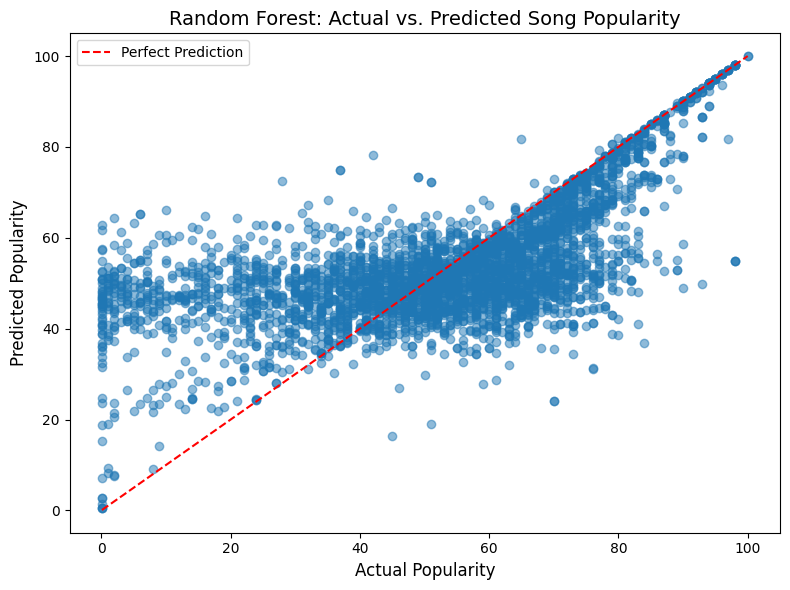

In [62]:
y_pred = rf_reg_model.predict(X_test) 

y_test_values = y_test['song_popularity'].values  

plt.figure(figsize=(8, 6))
plt.scatter(y_test_values, y_pred, alpha=0.5)  
plt.plot([min(y_test_values), max(y_test_values)], [min(y_test_values), max(y_test_values)], '--', color='red', label='Perfect Prediction')
plt.title('Random Forest: Actual vs. Predicted Song Popularity', fontsize=14)
plt.xlabel('Actual Popularity', fontsize=12)
plt.ylabel('Predicted Popularity', fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

The scatter plot reveals several key insights:

* **Moderate Accuracy with Dispersion:**  While the points generally follow a **positive trend**, indicating that the model captures the overall relationship between song features and popularity, there's a noticeable degree of dispersion around the "perfect prediction" line (represented by the red dashed line). This suggests that the model's predictions are not always highly accurate, with a margin of error present in its forecasts. 

* **Strength in Mid-Range Popularity:**  The model appears to be most accurate when predicting songs within the mid-range of popularity scores (**between 40 and 70**).  This is evident from the higher concentration of data points closer to the perfect prediction line within this range. 

* **The Influence of External Factors:**  The scatter plot reinforces a crucial understanding: song popularity is a complex phenomenon influenced by factors beyond the musical features we've analyzed. Marketing campaigns, social media buzz, critical acclaim, and even sheer luck can significantly impact a song's success. This explains the dispersion of points and the model's occasional larger errors, particularly for songs with higher actual popularity. 

**Key Takeaways:**

* **1. Talent Discovery:**  Let’s use our model to identify promising artists and songs early on, flagging those with above-average predicted popularity for A&R teams.

* **2. Playlist Curation:** We can help streaming services create more engaging playlists by prioritizing songs with higher predicted popularity, tailored to specific moods, genres, or listener preferences. 

* **3. Smarter Marketing:** Labels and artists can benefit from our insights by focusing their marketing efforts on songs with the greatest predicted potential for success. This ensures resources are allocated strategically for maximum impact. 

* **4.  Beyond Musical Features:** We can further refine our predictions by incorporating social media engagement metrics, sentiment analysis from reviews, and marketing campaign data. 

## Feature Importance: Unlocking the Drivers of Song Popularity

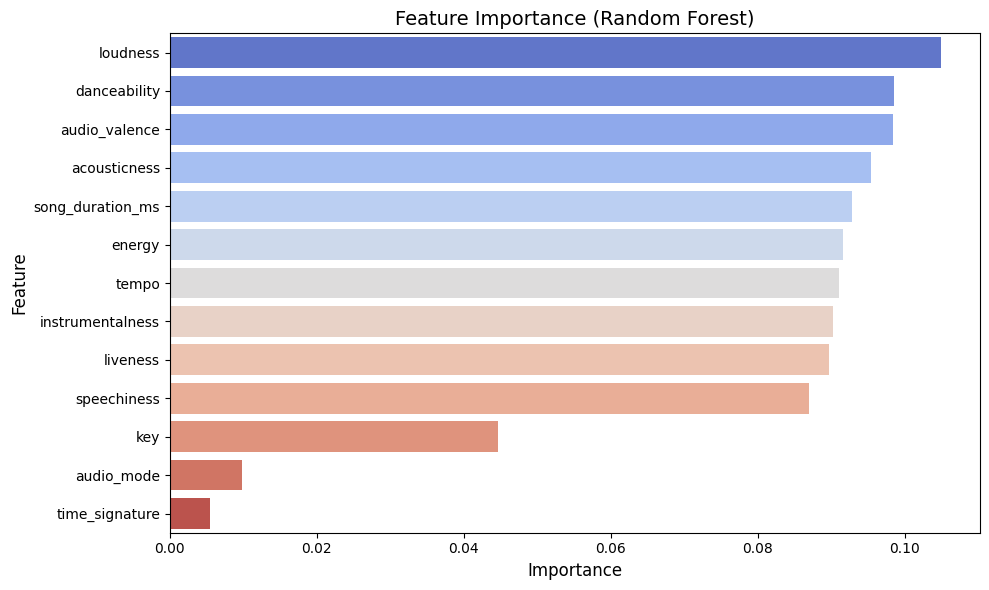

In [70]:
feature_importances = rf_reg_model.feature_importances_

features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette="coolwarm")
plt.title('Feature Importance (Random Forest)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

The feature importance plot derived from our **Random Forest model** unveils fascinating insights into the factors that most strongly influence a song's popularity:

> * **Loudness Matters Most:** The most striking finding is that **loudness** significantly impacts song popularity.  This could be due to the attention-grabbing nature of louder tracks or the prevalence of loudness normalization in streaming platforms, making louder songs sound more prominent.
>     * **Action:** Artists and producers should carefully consider loudness levels during mastering to maximize impact, especially within the context of streaming services. 


> * **Danceability and Valence Also Contribute:** "Danceability" and "audio valence" (positivity) also hold considerable weight, suggesting that upbeat and energetic songs with a positive vibe tend to perform better. 
>     * **Action:** Encouraging artists to explore themes of joy, hope, and optimism, while crafting music with a strong rhythmic groove, can boost a song’s appeal.


> * **Acousticness: A Balancing Act:**  "Acousticness" is another significant predictor, but its impact might be genre-dependent. In some genres, acoustic elements enhance appeal, while in others, they might be less effective.
>     * **Action:**  Data Money can further investigate the role of acousticness in specific genres to provide tailored insights to clients.


> * **Other Features: Less Impactful:** Features like "song duration," "tempo," "instrumentalness," and "speechiness" have a relatively lower impact, suggesting they play a less prominent role in overall popularity. 
>     * **Action:**  While these features may not be primary drivers of success, understanding their nuances within specific genres or contexts can still offer valuable insights.

# 5. Conclusion: Hit Potential, Unlocked. Insights from Predicting Song Popularity – And a Look Ahead

Our deep dive into the world of regression algorithms has yielded valuable insights, illuminating the path towards predicting song popularity with a data-driven edge. While achieving perfect prediction remains elusive – reflecting the inherent complexity of musical taste – our analysis reveals a clear winner and paves the way for strategic decision-making in the music industry. 

**Key Findings:**

* **Random Forest Takes Center Stage:** Our analysis highlighted Random Forest as the most effective model, surpassing traditional linear regression approaches. While achieving a moderate **R-squared of 0.407** on the test data, signifying that approximately 40% of the variability in song popularity can be explained by the features we analyzed, it also maintained a relatively low **RMSE of 16.99** and a **MAPE of 6.32%**.  These metrics, taken together, suggest that Random Forest can provide valuable, albeit not perfect, predictions about a song's potential to resonate with listeners.

* **The Power of Ensemble Methods and the Dominance of Loudness:** Random Forest's strength lies in its ability to combine multiple decision trees, mitigating the risk of overfitting that often hinders simpler models.  This ensemble approach allows it to capture more complex relationships within the data, leading to more robust and generalizable predictions. **Crucially, our feature importance analysis unveiled that *loudness* is the most influential factor in predicting song popularity. This highlights the importance of optimizing loudness levels during production to capture listener attention, particularly in the context of streaming platforms.** *Danceability*, *energy*, and *audio valence* also emerged as significant predictors, suggesting that upbeat, positive songs with a strong rhythmic groove tend to perform better. 

* **From Insights to Action – And Beyond:**  These findings offer exciting possibilities for Data Money and our clients. Imagine empowering talent scouts to identify promising artists early on, not just through intuition but backed by data-informed predictions, considering the critical role of loudness. 

    - **But we're not stopping there.** We recognize that predicting song popularity is not an exact science.  Our analysis underscores the influence of external factors beyond the musical features currently analyzed. Moving forward, we’ll actively pursue model refinement by incorporating social media trends, marketing data, and expert reviews to provide an even more holistic view of the factors driving song popularity.  We'll also continuously explore new algorithms and techniques, ensuring we're always pushing the boundaries of predictive accuracy and delivering cutting-edge insights to our clients.

This journey into song popularity prediction has underscored the power of data-driven decision-making in the music industry. By embracing advanced analytics and collaborating closely with our clients, **Data Money** is poised to *unlock new opportunities and shape the future of musical success*. 
